In [53]:
#!/usr/bin/env python
"""
Demo for CrossPhantom dynamic tomography test problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [1]:
import numpy as np
import time
import scipy.stats as sps
import matplotlib
import matplotlib.pyplot as plt
import astra
import pylops
from scipy.ndimage import convolve
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
import h5py
from trips.utilities.utils import *
from trips.utilities.io import *
from trips.utilities.operators import *
from trips.utilities.helpers import *
from scipy import sparse

# Notebook 1: CrossPhantom test problem

<p>In this example we illustrate the following:
<p>&nbsp; Step 1: Download/read the crossPhantom data and prepare them for processing.
<p>&nbsp; Step 2: Solve the static inverse problem.
<p>&nbsp; Step 3: Solve the dynamic inverse problem.

CrossPhantom data are generated at the University of Helsinki: https://zenodo.org/record/1341457

#### Step 1: Download/read the data and prepare them for processing
##### The main function to generate the emoji data is generate_crossPhantom(dataset, noise_level) 
<p> <b>Input:</b> 
<p>&nbsp; <b>dataset:</b>
        <p>&nbsp; if dataset = 15, we generate data from DataDynamic_128x15.mat
        <p>&nbsp; if dataset = 60, we generate data from DataDynamic_128x60.mat
<p>&nbsp; <b>noise_level:</b>
        <p>&nbsp; CrossPhantom data are real data and they have noise. Hence, we set noise_level = 0
            
<p> <b>Output:</b>  
&nbsp;<br> <b>A:</b> The full forward operator for all time instances<br>
&nbsp; <b>b:</b> All the data/measurements vectorized<br> 
&nbsp; <b>AA:</b> A list of 16 time-wise operators<br> 
&nbsp; <b>B:</b> A list of 16 data vectors for each time instance <br> 
&nbsp; <b>nx:</b> The dimension of the first spatial domain<br> 
&nbsp; <b>ny:</b> The dimension of the second spatial domain<br> 
&nbsp; <b>nt:</b> The dimension of the time instances domain<br> 
&nbsp; <b>delta:</b> The noise level in the data. When we set noise_level == 0, we get delta = 0<br> 
&nbsp; <b>sinoshape:</b> The dimension of the time-wise sinogram<br>     

In [2]:
(F, d, Aseq, B, nx, ny, nt) = generate_crossPhantom(dataset = 15)

Data already downloaded.


In [3]:
# Compute a solution by MMGKS
# Define the regularization operator
# L = spatial_derivative_operator(nx, ny, nt)
timestep = 5
A1 = Aseq[timestep]
b1 = B[timestep]
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks_1, info_mmgks_1) = MMGKS(A1, b1.reshape((-1,1)), L, pnorm = 2, qnorm = 1, projection_dim = 1, n_iter = 100, regparam = 'gcv', x_true = None, epsilon = 0.001)

running MMGKS...:   0%|          | 0/100 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


(-0.5, 127.5, 127.5, -0.5)

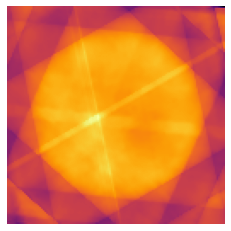

In [8]:
plt.imshow(x_mmgks_1.reshape((nx, ny)))
plt.set_cmap('inferno')
plt.axis('off')

#### Import and plot the ground truth image

In [9]:
f = spio.loadmat(f'./data/crossphantom_data/GroundTruthReconstruction2D.mat')

FileNotFoundError: [Errno 2] No such file or directory: './data/crossphantom_data/GroundTruthReconstruction2D.mat'

(-0.5, 2047.5, 2047.5, -0.5)

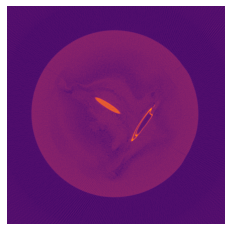

In [36]:
plt.imshow(f['recon'], cmap = 'inferno')
plt.axis('off')

### Show the sinogram for all the data 

(-0.5, 139.5, 79.5, -0.5)

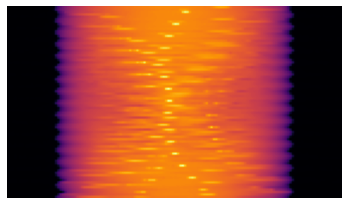

In [37]:
plt.imshow(b.reshape((80, 140)), cmap = 'inferno')
plt.axis('off')

### Show the sinogram for the first time instance 

In [38]:
plt.imshow(B[0].reshape((5, 140)), cmap = 'inferno')
plt.axis('off')

(-0.5, 139.5, 4.5, -0.5)

#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $F x = d$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $Aseq(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [50]:
# Compute a solution by MMGKS for a time instance
# Define a derivative operator as a regularization operator
# L = spatial_derivative_operator(nx, ny, nt)
timeinstance = 10
A1 = Aseq[timeinstance]
b1 = B[timeinstance]
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks_1, info_mmgks_1) = MMGKS(A1, b1.reshape((-1,1)), L, pnorm = 2, qnorm = 1, projection_dim = 1, n_iter = 100, regparam = 'gcv', x_true = None, epsilon = 0.1)

running MMGKS...:   0%|          | 0/100 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


(-0.5, 127.5, 127.5, -0.5)

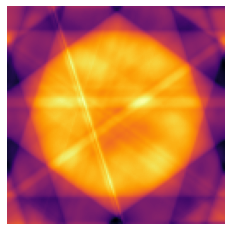

In [52]:
# x_mmgks_1[x_mmgks_1<0] = 0
plt.imshow(x_mmgks_1.reshape((nx, ny)))
plt.set_cmap('inferno')
plt.axis('off')

In [ ]:
xx = list(range(nt))
L = spatial_derivative_operator(nx, ny, 1)
for i in range(nt):
    b_vec = B[i].reshape((-1,1))
    (x_static_mmgks, info_mmgks) = MMGKS(Aseq[i], b_vec, L, pnorm=2, qnorm= 0.1, projection_dim=1, n_iter = 100, regparam= 'gcv' , x_true=None, epsilon = 0.001)
    xx[i] = x_static_mmgks

#### Plot reconstructed images one by one

#### Step 3: Solve dynamic inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [37]:
# Define the regularization operator
L = gen_spacetime_derivative_operator(nx, ny, nt)
data_vec = d.reshape((-1,1))
# Use MMGKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(F, data_vec, L, pnorm=2, qnorm= 1, projection_dim=1, n_iter = 100, regparam = 'gcv', x_true = None, epsilon = 0.1)

running MMGKS...: 100%|██████████| 100/100 [06:00<00:00,  3.60s/it]


#### Plot reconstruction images of the dynamic problem

In [23]:
# x_mmgks[x_mmgks<0] = 0

(-0.5, 127.5, 127.5, -0.5)

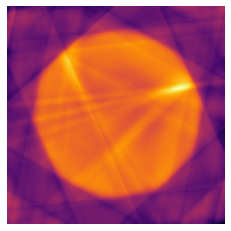

In [49]:
atens = x_mmgks.reshape((nt, ny, nx))
plt.imshow(atens[15, :, :])
plt.set_cmap('inferno')
plt.axis('off')

<Figure size 432x288 with 0 Axes>

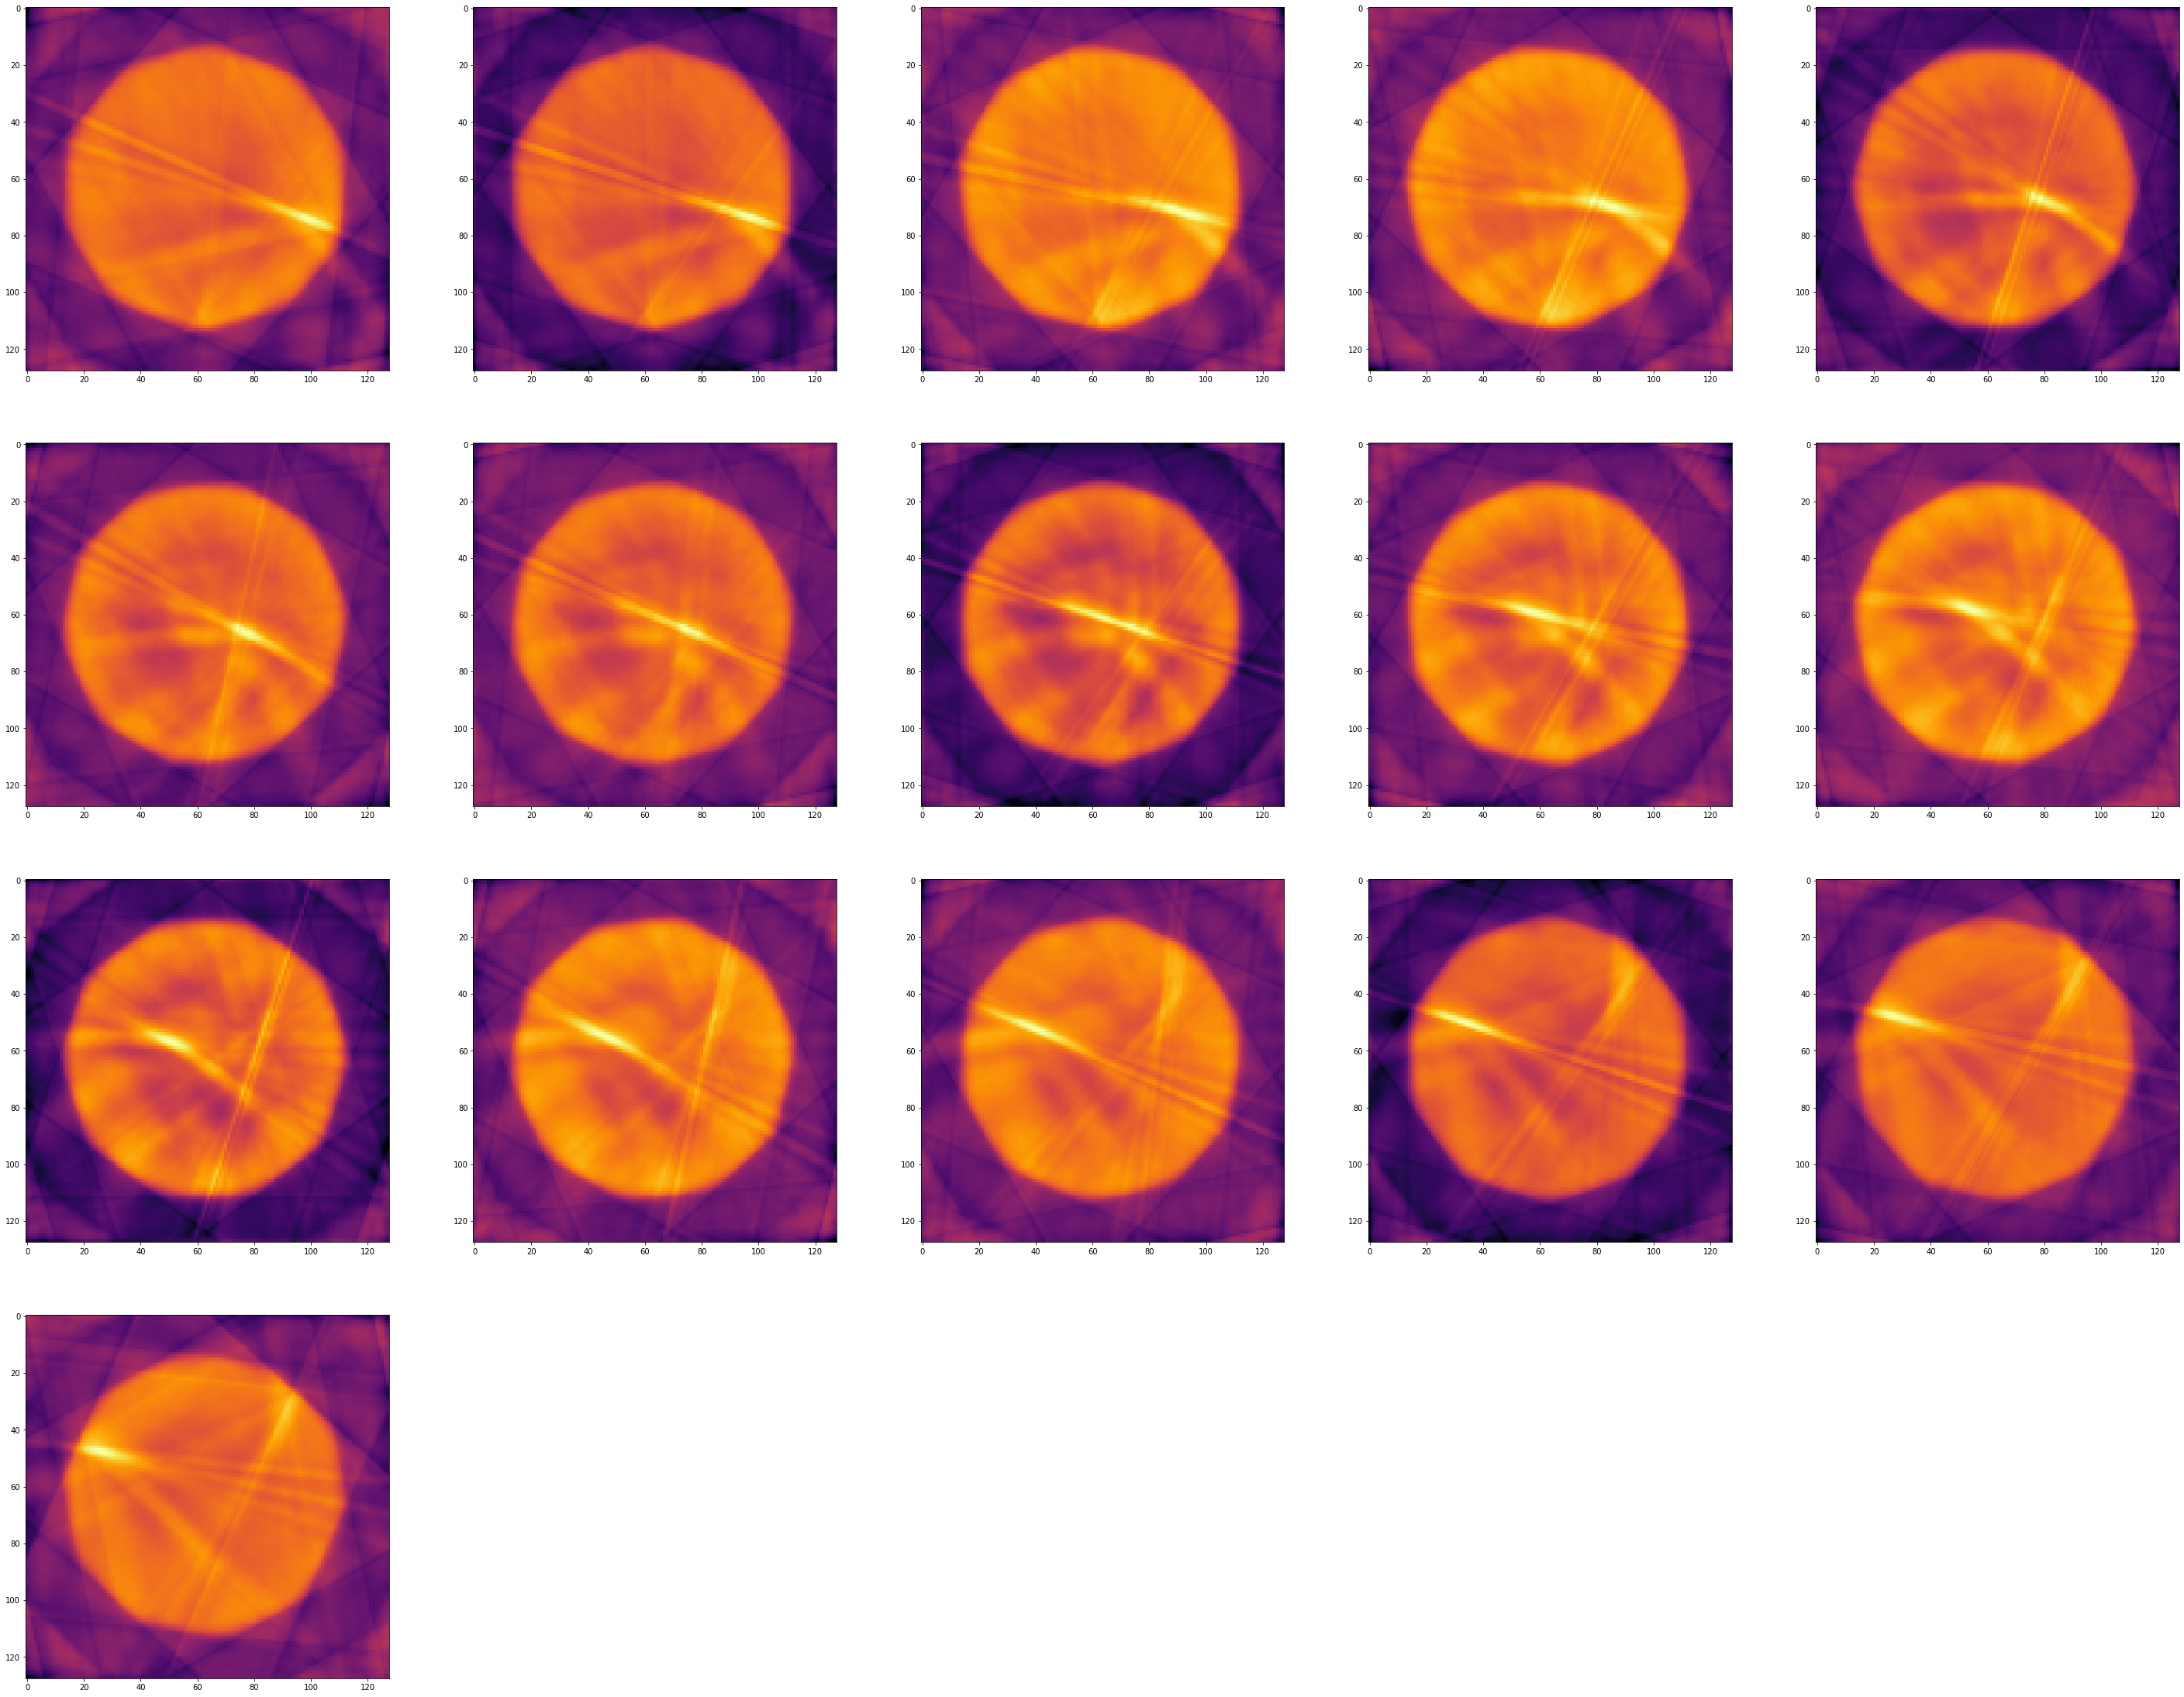

In [38]:
plot_recstructions_series(x_mmgks, (nx, ny, nt), dynamic = True, testproblem = 'crossPhantom', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/CrossPhantom')